<a href="https://colab.research.google.com/github/madhavi1102/natural_language_processing/blob/main/Topic_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with BERT

**NOTE**: This is significantly faster if you choose a **gpu** as runtime. 

In [15]:
!pip install umap-learn
!pip install -U sentence-transformers
!pip install hdbscan

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.3.8)


In [ ]:
import numpy as np
import pandas as pd

import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

## Load data
For this example, let's use the famous 20Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics.

In [ ]:
np.random.seed(0)
data = fetch_20newsgroups(subset='all')['data']

## Create embeddings
The very first step is converting the documents to numerical data. There are many methods that can be applied, but since we are modeling topics with **BERT** that is what we are going to be using.

There are many pre-trained models that you can use for a large amount of languages [here](https://www.sbert.net/docs/pretrained_models.html). Simply plug-in the name instead of *distilbert-base-nli-mean-tokens*. 

In [ ]:
%%time
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

100%|██████████| 245M/245M [00:17<00:00, 14.4MB/s]



CPU times: user 3min 57s, sys: 10 s, total: 4min 7s
Wall time: 4min 31s


## Reduce dimensionality
We use **UMAP** to reduce the dimensionality of the embeddings created above. It is important that we keep a little bit of dimensionality as that allows the reduced embeddings to contain more structure to improve clustering at a later stage. 

You can play around with the **number of components** (dimensionality to reduce to) and the **number of neighbors** (the nearby points to look at). 

In [ ]:
%%time
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings)

CPU times: user 45.9 s, sys: 1.63 s, total: 47.5 s
Wall time: 46.6 s


## Cluster documents
Since **UMAP** keeps some of the original high-embedded structure, it makes sense to use **HDBSCAN** to find highly-densed clusters. The metric is euclidean since it does not suffer from high-dimensionality and the **minimum cluster size** allows you to decrease the number of topics found and increase the topic sizes. 

In [ ]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

CPU times: user 846 ms, sys: 313 ms, total: 1.16 s
Wall time: 3.5 s


## Visualize Clusters
We can visualize the resulting cluster by embedding the data into **2d-space** using **UMAP** and using matplotlib to color the clusters. Some clusters are difficult to spot as there may be > 50 topics generated. 

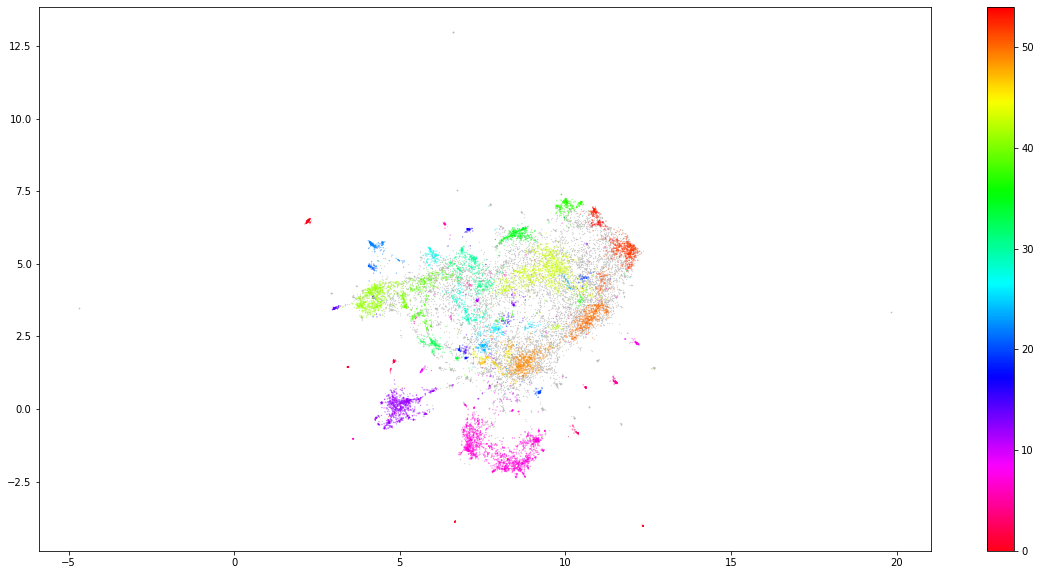

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
# plt.savefig("result1.png", dpi = 300)

## Prepare results
For easier selection, we put the results in a pandas dataframe. Then, *docs_per_label* is created in which all documents within a single cluster are joined. 

In [ ]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

## Calculate word importance per topic
Calculate the importance of words  in a topic compared to all other topics by considering all documents in a topic to be a single document instead before applying **TF-IDF**. Then, we simply extract the words with the highest values in each cluster as a representative of a topic. 

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data))

In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,8377
8,7,1761
44,43,1090
13,12,966
42,41,705
53,52,516
51,50,507
50,49,500
36,35,373
38,37,282


In [ ]:
top_n_words[7][:10]

[('game', 0.010457064574205876),
 ('team', 0.009330623698817741),
 ('hockey', 0.008341477022610098),
 ('games', 0.006831457696895118),
 ('players', 0.006753830927421891),
 ('play', 0.006293209317999615),
 ('season', 0.006227752030983029),
 ('baseball', 0.0060984850344868195),
 ('year', 0.005789161738305711),
 ('nhl', 0.005736180378958607)]

## Topic Reduction

In [ ]:
for i in tqdm(range(20)):
  # Calculate cosine similarity
  similarities = cosine_similarity(tf_idf.T)
  np.fill_diagonal(similarities, 0)

  # Extract label to merge into and from where
  topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
  topic_to_merge = topic_sizes.iloc[-1].Topic
  topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1
  
  # Adjust topics
  docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
  old_topics = docs_df.sort_values("Topic").Topic.unique()
  map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
  docs_df.Topic = docs_df.Topic.map(map_topics)
  docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

  # Calculate new topic words
  m = len(data)
  tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
  top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

100%|██████████| 20/20 [02:37<00:00,  7.89s/it]


,Topic,Size
0,-1,8377
4,3,1793
27,26,1341
6,5,1001
26,25,752
29,28,631
32,31,516
30,29,507
21,20,413
22,21,320
